In [1]:
import skrf as rf
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
# Generates cal csv through combiation of Josh's S11 measuresments and Henriks Phase Measurements.
# Through changing vars for rf.Frequency, interpolation can be matched to number of required samples.

l = rf.Network('data/cal_kit/load.s1p')
o = rf.Network('data/cal_kit/open.s1p')
s = rf.Network('data/cal_kit/short.s1p')

l_agilent = np.loadtxt("data/agilent_vna/LOADS11.csv", delimiter=",")
o_agilent = np.loadtxt("data/agilent_vna/OPENS11.csv", delimiter=",")
s_agilent = np.loadtxt("data/agilent_vna/SHORTS11.csv", delimiter=",")

freq = rf.Frequency(25,1250,1226,'mhz')

l_i = l.interpolate(freq)
o_i = o.interpolate(freq)
s_i = s.interpolate(freq)

frequencies = l_i.f
l_array = np.zeros((len(frequencies), 3))
o_array = np.zeros((len(frequencies), 3))
s_array = np.zeros((len(frequencies), 3))

for i in range(len(frequencies)):
    l_array[i, 0] = frequencies[i]
    l_array[i, 1] = l_agilent[i, 1]
    l_array[i, 2] = l_i.s_deg[i]
    
    o_array[i, 0] = frequencies[i]
    o_array[i, 1] = o_agilent[i, 1]
    o_array[i, 2] = o_i.s_deg[i]
    
    s_array[i, 0] = frequencies[i]
    s_array[i, 1] = s_agilent[i, 1]
    s_array[i, 2] = s_i.s_deg[i]

np.savetxt("data/cal_kit/cal_load_interp.csv", l_array, delimiter=",")
np.savetxt("data/cal_kit/cal_short_interp.csv", o_array, delimiter=",")
np.savetxt("data/cal_kit/cal_open_interp.csv", s_array, delimiter=",")

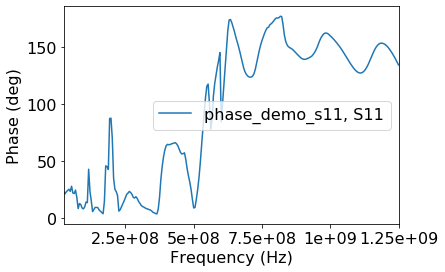

In [76]:
# Trying to find peaks and then determine phase from AD8302

def data_to_network(file_name, freq, mag, phase):
    s = np.zeros((len(freq), 2, 2), dtype=complex)
    fn = file_name.lower()
    if 's11' in fn or 'open' in fn or 'short' in fn or 'load' in fn or 'one' in fn:
        s[:, 0, 0] = rf.dbdeg_2_reim(mag, phase)
    elif 's21' in fn or 'thru' in fn or 'through' in fn or 'two' in fn:
        s[:, 1, 0] = rf.dbdeg_2_reim(mag, phase)
    else:
        var = input("Unable to determine S param, please enter S11 or S21")
        if "s11" in var:
            s[:, 0, 0] = rf.dbdeg_2_reim(mag, phase)
        elif "s21" in var:
            s[:, 1, 0] = rf.dbdeg_2_reim(mag, phase)
        else:
            print("Still unable to figure it out, try changing file name")

    network = rf.Network(f=freq, s=s, name=file_name)
    return network

def load(file_name):
    """ Loads CSV from file. """
    global network
    data = np.loadtxt("{}.csv".format(file_name), delimiter=",")
    freq = data[:, 0]
    mag = data[:, 1]
    phase = data[:, 2]
    network = data_to_network(file_name, freq, mag, phase)
    network.frequency = network.frequency * 1E-6
    return network

network = rf.Network("phase_demo_s11.s1p")

network.plot_s_deg(m=0, n=0)
freq = network.f * 1E-6
phase = network.s_deg[:,0,0]

In [77]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

window_width = int(len(freq) / 1226 * 20)
print(window_width)
phase_filt = running_mean(phase, window_width)

offset = int(0.5 * window_width - 1)
freq = freq[:-offset]
phase = phase[offset:]

height = 168
distance = len(phase_filt) / 10

# find peaks and valleys
peaks = signal.find_peaks(phase_filt, height=height, distance=distance)
print(peaks)
peaks_freq = freq[peaks[0]]
peaks_phase = phase_filt[peaks[0]]

valleys = signal.find_peaks(180 - phase_filt, height=height, distance=distance)
valleys_freq = freq[valleys[0]]
valleys_phase = phase_filt[valleys[0]]

# generate array of key points

key_freq = []
key_phase = []

key_freq.append(freq[0])
key_phase.append(phase[0])

if len(peaks_freq) and len(valleys_freq):
    if peaks_freq[0] < valleys_freq[0]:
        peaks_first = 1;
    else:
        peaks_first = 0;

while len(peaks_freq) or len(valleys_freq):

    if len(peaks_freq) and peaks_first:
        key_freq.append(peaks_freq[0])
        key_phase.append(180)
        peaks_freq = peaks_freq[1:]


    if len(valleys_freq):
        key_freq.append(valleys_freq[0])
        key_phase.append(0)
        valleys_freq = valleys_freq[1:]
    
    peaks_first = 1
        
key_freq.append(freq[-1])
key_phase.append(phase[-1])

phase_corr = []
j = 0
i = 0
while i < len(freq):
    # if between key frequencies
    if freq[i] >= key_freq[j] and freq[i] <= key_freq[j+1]:
        # if slope positive, phase negative
        if key_phase[j] <= key_phase[j+1]:
            phase_corr.append(-phase[i])
        # if slope negative, phase positive
        else:
            phase_corr.append(phase[i])
        i = i + 1
    # if above freq, increase ref frequencies
    else:
        j = j + 1

4
(array([126, 163], dtype=int64), {'peak_heights': array([171.7825, 176.285 ])})


<Figure size 432x288 with 0 Axes>

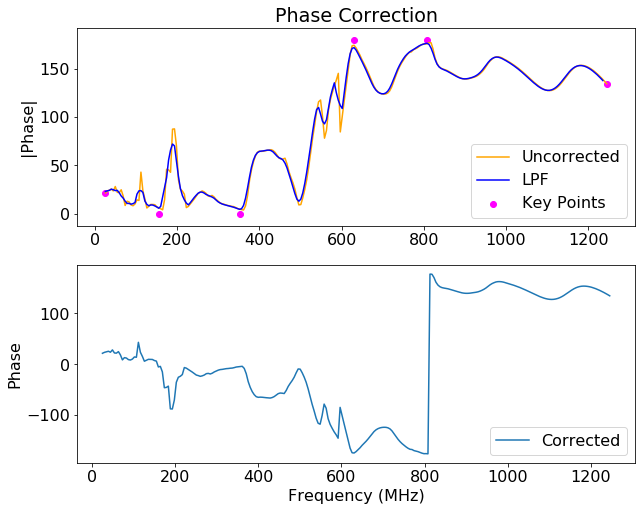

In [78]:
plt.figure()
plt.figure(figsize=(10.0, 8.0))
plt.subplot(2,1,1)
plt.title("Phase Correction")
plt.plot(freq, phase, label = "Uncorrected", color = "orange")
plt.plot(freq[:len(phase_filt)],phase_filt, label = "LPF", color = "blue")
plt.scatter(key_freq, key_phase, marker = "o", color = "magenta", label = "Key Points")
plt.rcParams.update({'font.size': 16})
plt.ylabel("|Phase|")
# plt.xlabel("Frequency (MHz)")
plt.legend(loc='lower right')

plt.subplot(2,1,2)
plt.plot(freq,phase_corr, label = "Corrected")
plt.rcParams.update({'font.size': 16})
plt.ylabel("Phase")
plt.xlabel("Frequency (MHz)")
plt.legend(loc="lower right")
plt.savefig("phase_correction_2")